In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

     |████████████████████████████████| 1.8MB 8.7MB/s 
     |████████████████████████████████| 890kB 28.5MB/s 
     |████████████████████████████████| 2.9MB 44.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=08be4ce3581df8746fcfdd97d176ce5891e11677215996d5d35481e2d3849ad2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import Parameter
from transformers import BertModel
from transformers import BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.optim as optim
import copy

In [ ]:
from transformers import BertLayer
import pickle

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_df(file):
    return pd.read_csv(file, sep='|',header = None)

In [ ]:
train_df_fake = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/train_rumor.txt')
train_df_real = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/train_nonrumor.txt')
test_df_fake = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/test_rumor.txt')
test_df_real = get_df('/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/tweets/test_nonrumor.txt')

In [ ]:
train_df_fake

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3511947309647762,地球超级爆料,http://weibo.com/2803550292/z50NQEtP4,NaN,2012-11-13 16:55,true,79,18,0,2803550292,0.0,5047.0,1770.0,1979.0,微博 weibo.com
1,http://ww1.sinaimg.cn/large/a71ac854gw1dytin2z...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,震惊，转发求证：【想都不敢想 ，在美国一桶金龙鱼食用油只要8元人民币】 一桶食用油相当于中国...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3576100079039606,Noodles_Liu,http://weibo.com/1000432103/zvVI3BVC6,NaN,2013-05-09 17:36,true,1,0,0,1000432103,0.0,9049.0,490.0,28017.0,iPhone客户端
4,http://ww1.sinaimg.cn/large/3ba161e7jw1e4i6j4e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11189,3795205020509978,雯雯兜兜2,http://weibo.com/5221338222/BDWIu28Fs,NaN,2015-01-04 07:30,true,0,4,11942,5221338222,0.0,146.0,169.0,622.0,iPhone 5s
11190,http://ww2.sinaimg.cn/large/a716fd45jw1enx4x69...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x6d...,http://ww3.sinaimg.cn/large/a716fd45jw1enx4x6k...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x6q...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x6r...,http://ww4.sinaimg.cn/large/a716fd45jw1enx4x70...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x71...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x75...,http://ww1.sinaimg.cn/large/a716fd45jw1enx4x7e...,NaN,NaN,NaN,NaN,NaN,NaN
11191,3720633525700857,D-雨中伞,http://weibo.com/3071526677/B8ELSnV3j,NaN,2014-01-02 17:01,true,0,0,968,3071526677,0.0,96.0,108.0,16.0,iPhone客户端
11192,http://ww4.sinaimg.cn/large/668669eagw1ec59jtc...,http://ww3.sinaimg.cn/large/668669eagw1ec59k3d...,http://ww3.sinaimg.cn/large/668669eagw1ec59k4k...,http://ww3.sinaimg.cn/large/668669eagw1ec59k75...,http://ww4.sinaimg.cn/large/668669eagw1ec59k9w...,http://ww2.sinaimg.cn/large/668669eagw1ec59kdv...,http://ww4.sinaimg.cn/large/668669eagw1ec59kxd...,http://ww2.sinaimg.cn/large/668669eagw1ec59kzu...,http://ww1.sinaimg.cn/large/668669eagw1ec59l1t...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_fake = train_df_fake[0].tolist()
train_real = train_df_real[0].tolist()
test_fake = test_df_fake[0].tolist()
test_real = test_df_real[0].tolist()

In [ ]:
def fix_offset(list_):
    fixed_flag = False

    while not fixed_flag:
        exit_flag=False
        temp = copy.deepcopy(list_)
        for i,v in enumerate(temp):
            if v!=None:
                if 'sinaimg.cn' in v:
                    if list_[i+1] !=None:
                        if list_[i+1].isdigit():
                            list_.insert(i+1,None)
                            exit_flag=True
                            break
        if not exit_flag:
            fixed_flag=True
            
    return list_

In [ ]:
train_fake = fix_offset(train_fake) 
train_real = fix_offset(train_real)
test_fake = fix_offset(test_fake)
test_real = fix_offset(test_real)

In [ ]:
def break_in_block(list_):
    temp = []
    for i in range(0,len(list_),3):
        temp.append(list_[i:i+3])
    return temp

In [ ]:
train_fake = break_in_block(train_fake)
train_real = break_in_block(train_real)
test_fake = break_in_block(test_fake)
test_real = break_in_block(test_real)

In [ ]:
len(train_fake),len(train_real),len(test_fake),len(test_real)

(3748, 3783, 1000, 996)

In [ ]:
train_fake[0]

['3511947309647762',
 'http://ww1.sinaimg.cn/large/a71ac854gw1dytin2zmk9j.jpg',
 '震惊，转发求证：【想都不敢想 ，在美国一桶金龙鱼食用油只要8元人民币】 一桶食用油相当于中国超市40多元(现在估计已经涨到五六十元了)的金龙鱼，在纽约沃尔玛感恩节时是1.6美元，圣诞节降至1.3美元。(折合人民币8.58元，而且油是绿色纯天然的，不是转基因的)，为什么中国一桶食用油要卖几十上百元？']

In [ ]:
def get_image_and_text_list(blocks_list):
    image_list = []
    text_list = []
    for i in blocks_list:
        if i[-1] !=None:
            image_list.append(i[1])
            text_list.append(i[-1])
    image_list = [i.split('/')[-1] for i in image_list]
    return image_list, text_list

In [ ]:
train_fake_image,train_fake_text = get_image_and_text_list(train_fake)
train_real_image,train_real_text = get_image_and_text_list(train_real)
test_fake_image,test_fake_text = get_image_and_text_list(test_fake)
test_real_image,test_real_text = get_image_and_text_list(test_real)

In [ ]:
train_fake_Y = [0]*len(train_fake_image)
train_real_Y = [1]*len(train_real_image)
test_fake_Y = [0]*len(test_fake_image)
test_real_Y = [1]*len(test_real_image)

In [ ]:
train_images = train_fake_image+train_real_image
train_text = train_fake_text + train_real_text
trainY = train_fake_Y+train_real_Y

test_images = test_fake_image+test_real_image
test_text = test_fake_text+test_real_text
testY = test_fake_Y+test_real_Y

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [ ]:
train_images = np.array(train_images)
train_text = np.array(train_text)
trainY = np.array(trainY)
test_images = np.array(test_images)
test_text = np.array(test_text)
testY = np.array(testY)

In [ ]:
from os import walk
def get_total_images() :
  mypath = "/content/drive/My Drive/multi-modal/weibo/airsplay/feat_rumor/"
  mypath1 = "/content/drive/My Drive/multi-modal/weibo/airsplay/feat_nonrumor/"
  img_feat = []
  for (dirpath, dirnames, filenames) in walk(mypath):
      img_feat.extend(filenames)
      break
  print("Read feat rumor")
  for (dirpath, dirnames, filenames) in walk(mypath1):
      img_feat.extend(filenames)
      break 
  print("Read feat nonrumor")
  mypath3 = "/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/rumor_images/"
  images = []
  for (dirpath, dirnames, filenames) in walk(mypath3):
      images.extend(filenames)
      break
  print("Read feat rumor")
  mypath4 = "/content/drive/My Drive/WeiboRumorSet/WeiboRumorSet/nonrumor_images/"
  for (dirpath, dirnames, filenames) in walk(mypath4):
      images.extend(filenames)
      break
  print("Read feat non rumor")
  img_dict = {}
  for img in images :
    img_dict[img[:-4]] = img
  total_img = []
  for img in img_feat :
    total_img.append(img_dict[img[:-4]])
  return total_img

In [ ]:
total_images = get_total_images()

Read feat rumor
Read feat nonrumor
Read feat rumor
Read feat non rumor


In [ ]:
def index_to_delete(list_, total_images):
    # list_images_dir = listdir('WeiboRumorSet/images/')
    gif_list = ['957e1cf2tw1e5foxts295g206o03p4qp.gif','a716fd45jw1ev0cgf8j46g209505zh4i.gif','005vnhZYgw1evupo8ttddg308w06o4qp.gif','7da75521gw1ele2jvi85rg2096056u0x.gif']
    index = []
    for i,v in enumerate(list_):
        if v not in total_images:
            index.append(i)
        # if v in gif_list:
        #     index.append(i)
    return index

In [ ]:
train_delete_index =index_to_delete(train_images, total_images)
test_delete_index = index_to_delete(test_images, total_images)
len(train_delete_index)+len(test_delete_index)

4147

In [ ]:
train_images = np.delete(train_images,train_delete_index)
train_text = np.delete(train_text,train_delete_index)
trainY = np.delete(trainY,train_delete_index)
test_images = np.delete(test_images,test_delete_index)
test_text = np.delete(test_text,test_delete_index)
testY = np.delete(testY,test_delete_index)

In [ ]:
shuffle_index= np.arange(len(train_images))
np.random.shuffle(shuffle_index)
train_images = train_images[shuffle_index]
train_text = train_text[shuffle_index]
trainY = trainY[shuffle_index]

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(4140, 4140, 4140, 1124, 1124, 1124)

In [ ]:
dict_class = {}
mypath = "/content/drive/My Drive/multi-modal/weibo/airsplay/feat_rumor/"
mypath1 = "/content/drive/My Drive/multi-modal/weibo/airsplay/feat_nonrumor/"
img_feat = []
for (dirpath, dirnames, filenames) in walk(mypath):
    img_feat.extend(filenames)
    break
for img in img_feat :
  dict_class[img[:-4]] = "rumor"
print("Read feat rumor")
img_feat1 = []
for (dirpath, dirnames, filenames) in walk(mypath1):
    img_feat1.extend(filenames)
    break 
for img in img_feat1 :
  dict_class[img[:-4]] = "nonrumor"

Read feat rumor


In [ ]:
dict_feat = {}



FileNotFoundError: ignored

In [ ]:
for key in dict_class :
  if(key not in dict_feat) :
    if (dict_class[key]=="rumor") :
      dict_feat[key] = pickle.load(open("/content/drive/My Drive/multi-modal/weibo/airsplay/feat_rumor/"+key+".pkl","rb"))
    else :
      dict_feat[key] = pickle.load(open("/content/drive/My Drive/multi-modal/weibo/airsplay/feat_nonrumor/"+key+".pkl","rb"))

In [ ]:
len(list(dict_feat.keys()))

13252

In [ ]:
c=0
shape_not_match = []
for key in dict_feat :
  if(dict_feat[key].shape[0]!=36) :
    shape_not_match.append(key)
    c+=1
print(c)
print(len(shape_not_match))

1768
1768


In [ ]:
# dict_feat

{'boston_fake_01': tensor([[0.0000, 0.0000, 0.1114,  ..., 0.0000, 0.0000, 0.1616],
         [0.3131, 0.0000, 0.0953,  ..., 1.7216, 4.9124, 0.1339],
         [0.0051, 0.0143, 0.1978,  ..., 0.0000, 0.0777, 0.0242],
         ...,
         [0.0000, 0.0906, 0.0000,  ..., 0.0000, 0.8309, 1.2299],
         [0.0000, 0.2076, 0.0000,  ..., 0.0000, 1.5466, 1.0192],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0165, 0.0000]],
        device='cuda:0'),
 'boston_fake_02': tensor([[7.3643e-01, 0.0000e+00, 0.0000e+00,  ..., 5.8619e-01, 3.4072e+00,
          1.1376e+00],
         [2.9675e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4900e-01,
          8.7860e-03],
         [2.9675e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4900e-01,
          8.7860e-03],
         ...,
         [0.0000e+00, 4.0595e+00, 0.0000e+00,  ..., 0.0000e+00, 6.4569e+00,
          2.6250e-01],
         [0.0000e+00, 1.9439e-01, 0.0000e+00,  ..., 2.9255e+00, 1.0126e+01,
          0.0000e+00],
         [0.0000e+00, 5.

In [ ]:
fin_train_img = []
c=0
ids_train = []
for i in range(len(train_images)) :
  main_image = train_images[i]
  if((main_image[:-4] not in shape_not_match)) :
    fin_train_img.append(main_image)
    ids_train.append(i)
    c+=1

print(c)
print(len(ids_train))
print(len(fin_train_img))

3617
3617
3617


In [ ]:
# dict_feat_test = {}

# for file_name in pickle_img_test :
#   dict_feat_test[file_name[:-4]] =  pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"+file_name,"rb"))

In [ ]:
# c=0
# shape_not_match_test = []
# for key in dict_feat_test :
#   if(dict_feat_test[key].shape[0]!=36) :
#     shape_not_match_test.append(key)
#     c+=1
# print(c)
# print(len(shape_not_match_test))

9
9


In [ ]:
fin_test_img = []
c=0
ids_test = []
for i in range(len(test_images)) :
  main_image = test_images[i]
  if (main_image[:-4] not in shape_not_match) :
    fin_test_img.append(main_image)
    ids_test.append(i)
    c+=1

print(c)
print(len(ids_test))
print(len(fin_test_img))

972
972
972


In [ ]:
train_input_img = torch.zeros((3617,36,2048))
train_output_img = torch.zeros((3617,1))

for i in range(len(fin_train_img)) :
  main_image = fin_train_img[i]
  index = ids_train[i]
  train_input_img[i] = dict_feat[main_image[:-4]]
  train_output_img[i] = trainY[index]


# for i in range(len(train_img)) :
#   img = train_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_images = img.split(',')
#     for img in main_images :
#       if((img in train_img_data) :
#         main_image = img
#         break 
#   else :
#     main_image = img
#   if(main_image in train_img_data)
#     if (main_image not in dict_feat) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"+main_image+".pkl","rb"))
#       dict_feat[main_image] = ar
#     else :
#       ar = dict_feat[main_image]
#     train_input_img[count] = ar
#     train_output_img[count] = y_train[i]
#     ids_train.append(i)
#     count+=1
#   except :
#     tr_img_not_found.append(main_image)
#     continue

In [ ]:
len(ids_train)

3617

In [ ]:
test_input_img = torch.zeros((972,36,2048))
test_output_img = torch.zeros((972,1))

for i in range(len(fin_test_img)) :
  main_image = fin_test_img[i]
  index = ids_test[i]
  test_input_img[i] = dict_feat[main_image[:-4]]
  test_output_img[i] = testY[index]

# for i in range(len(test_img)) :
#   img = test_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_image = img.split(',')[0]
#   else :
#     main_image = img
#   try: 
#     if (main_image not in dict_feat_test) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"+main_image+".pkl","rb"))
#       dict_feat_test[main_image] = ar
#     else :
#       ar = dict_feat_test[main_image]
#     test_input_img[count] = ar
#     test_output_img[count] = y_test[i] 
#     ids_test.append[i]
#     count+=1 
#   except :
#     ts_img_not_found.append(main_image)
#     continue

In [ ]:
print(len(train_input_img))
print(len(train_output_img))

3617
3617


In [ ]:
# len(test)

In [ ]:
# dict_feat = {}

In [ ]:
# train_input = torch.zeros((12968,36,2048))
# train_output = torch.zeros((12968,1))
# count=0
# for i in range(len(train_img)) :
#   img = train_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_image = img.split(',')[0]
#   else :
#     main_image = img
#   try: 
#     if (main_image not in dict_feat) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"+main_image+".pkl","rb"))
#       dict_feat[main_image] = ar
#     else :
#       ar = dict_feat[main_image]
#     train_input[count] = ar
#     train_output[count] = y_train[i]
#     count+=1
#   except :
#     continue

In [ ]:
# dict_feat_test = {}

In [ ]:
# test_input = torch.zeros((1040,36,2048))
# test_output = torch.zeros((1040,1))
# count=0
# for i in range(len(test_img)) :
#   img = test_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_image = img.split(',')[0]
#   else :
#     main_image = img
#   try: 
#     if (main_image not in dict_feat_test) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"+main_image+".pkl","rb"))
#       dict_feat_test[main_image] = ar
#     else :
#       ar = dict_feat_test[main_image]
#     test_input[count] = ar
#     test_output[count] = y_test[i] 
#     count+=1 
#   except :
#     continue

In [ ]:
# print(len(train_input))
# print(len(train_output))

12968
12968


In [ ]:
# test_input.shape

torch.Size([1040, 36, 2048])

In [ ]:
# print(len(test_input))
# print(len(test_output))

1040
1040


In [ ]:
len(test_img.unique())

130

In [ ]:
def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class BERTLayerNorm(nn.Module):
    def __init__(self, config, variance_epsilon=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(BERTLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(config.hidden_size))
        self.beta = nn.Parameter(torch.zeros(config.hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class BERTSelfAttention(nn.Module):
    def __init__(self, config):
        super(BERTSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class BERTSelfOutput(nn.Module):
    def __init__(self, config):
        super(BERTSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BERTAttention(nn.Module):
    def __init__(self, config):
        super(BERTAttention, self).__init__()
        self.self = BERTSelfAttention(config)
        self.output = BERTSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BERTIntermediate(nn.Module):
    def __init__(self, config):
        super(BERTIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BERTOutput(nn.Module):
    def __init__(self, config):
        super(BERTOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BERTLayer(nn.Module):
    def __init__(self, config):
        super(BERTLayer, self).__init__()
        self.attention = BERTAttention(config)
        self.intermediate = BERTIntermediate(config)
        self.output = BERTOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [ ]:
class TransformerMapping(nn.Module):
    """ Self-attention layer for image branch
    """
    def __init__(self):
        super(TransformerMapping, self).__init__()
        bert_config = BertConfig.from_json_file("t_cfg.json")
        self.layer = BERTLayer(bert_config)
        self.mapping = nn.Linear(2048, 256)
        #self.mapping2 = nn.Linear(opt.final_dims, opt.final_dims)
        self.cls_layer = nn.Linear(256, 1)

    def forward(self, x):
        # x: (batch_size, patch_num, img_dim)
        # print("x", x.shape)
        x = self.mapping(x) # x: (batch_size, patch_num, final_dims)
        # print("x_mapping", x.shape)
        attention_mask = torch.ones(x.size(0), x.size(1))
        if torch.cuda.is_available():
            attention_mask = attention_mask.cuda()
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.float()
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        hidden_states = self.layer(x, extended_attention_mask)
        # print("hidden_states",hidden_states.shape)
        # hidden_states = self.mapping2(hidden_states)
        embed = torch.mean(hidden_states, 1) # (batch_size, final_dims)
        codes = F.normalize(embed, p=2, dim=1)  # (N, C)
        codes = self.cls_layer(codes)
        return codes

In [ ]:
# x_train = train_df['post_text']
# x_test = test_df['post_text']
# y_train = train_df['label'].eq('real').astype(int)
# y_test = test_df['label'].eq('real').astype(int)

In [ ]:
# train_input = np.array(train_input)
# train_output = np.array(train_output)
# test_input = np.array(test_input)
# test_output = np.array(test_output)

In [ ]:
# train_input.shape

In [ ]:
sum(trainY), len(trainY)

(795, 4140)

In [ ]:
sum(testY), len(testY)

(262, 1124)

In [ ]:
1/795

0.0012578616352201257

In [ ]:
1/3345

0.00029895366218236175

In [ ]:
weights = [0.00029895366218236175, 0.0012578616352201257]
sample_weights = [weights[t.int()] for t in train_output_img]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
batch_size = 32

train_data = TensorDataset(train_input_img,train_output_img)
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=1590)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
test_data = TensorDataset(test_input_img, test_output_img)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

In [ ]:
def get_labels_from_logits(logits) :
  probs = torch.sigmoid(logits.unsqueeze(-1))
  soft_probs = (probs > 0.5).long()
  labels = soft_probs.squeeze()
  return labels

In [ ]:
from sklearn.metrics import classification_report
def eval_model(model, val_loader, criterion) :
  model.eval()
  final_out = []
  final_lab = []

  loss_val = 0
  for idx, (val_input, val_label) in enumerate(val_loader):
      val_input = val_input.cuda()
      output = model(val_input)
      val_label = val_label.cuda()
      loss = criterion(output.squeeze(-1), val_label.float().squeeze(-1))
      loss_val+= loss.data
      output = get_labels_from_logits(output)
      output = output.cpu().detach().numpy()
      val_label = val_label.cpu().detach().numpy()

      final_out.extend(list(output))
      final_lab.extend(list(val_label))

      del val_input
      del val_label
      del output
      torch.cuda.empty_cache()

        
  return classification_report(final_lab, final_out), loss_val

In [ ]:
def train(net, criterion, opti, train_loader, num_epochs, val_loader):
  loss_train = []
  loss_test = []
  for epoch in range(num_epochs):
    loss_val = 0
    num_lab = 0
    sum_lab = 0
    for it, (seq, labels) in enumerate(train_loader):
        #Clear gradients
        opti.zero_grad()  
        #Converting these to cuda tensors
        seq, labels = seq.cuda(), labels.cuda()
        num_lab += labels.shape[0]
        sum_lab += torch.sum(labels)

        #Obtaining the logits from the model
        logits = net(seq)

        #Computing loss
        loss = criterion(logits.squeeze(-1), labels.float().squeeze(-1))
        loss_val += loss.data

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if (it + 1) % 20 == 0:
            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(it+1, epoch+1, loss.item(), acc))

        del seq
        del labels
        del logits
        del loss
        torch.cuda.empty_cache()

    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss_val))
    loss_train.append(loss_val)
    if((epoch+1)%1==0) :
      report, loss_t = eval_model(net, val_loader, criterion)
      loss_test.append(loss_t)
      print("loss_test", loss_t)
      print("classification_report")
      print(report)
    print("--------------------------------------------------------------")
    print(num_lab)
    print(sum_lab)
  return loss_train, loss_test

In [ ]:
net = TransformerMapping().to(device)
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(net.parameters(), lr = 1e-3)
loss_train, loss_test = train(net, criterion, opti, train_dataloader, 20, test_dataloader)

Iteration 20 of epoch 1 complete. Loss : 0.6909098625183105 Accuracy : 0.53125
Iteration 40 of epoch 1 complete. Loss : 0.6874703168869019 Accuracy : 0.5625
Epoch [1/20], Loss:34.6921


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss_test tensor(21.3122, device='cuda:0')
classification_report
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       746
         1.0       0.00      0.00      0.00       226

    accuracy                           0.77       972
   macro avg       0.38      0.50      0.43       972
weighted avg       0.59      0.77      0.67       972

--------------------------------------------------------------
1590
tensor(796., device='cuda:0')
Iteration 20 of epoch 2 complete. Loss : 0.6909043788909912 Accuracy : 0.490234375
Iteration 40 of epoch 2 complete. Loss : 0.6529642343521118 Accuracy : 0.5
Epoch [2/20], Loss:34.3069
loss_test tensor(18.9993, device='cuda:0')
classification_report
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       746
         1.0       0.00      0.00      0.00       226

    accuracy                           0.77       972
   macro avg       0.38      0.50      0.4

In [ ]:
import matplotlib.pyplot as plt

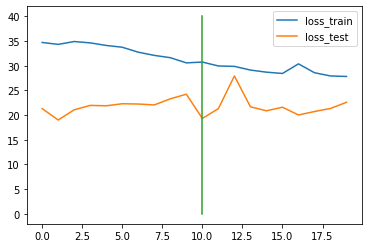

In [ ]:
plt.figure()
plt.plot(loss_train, label="loss_train")
plt.plot(loss_test, label="loss_test")
plt.plot([10,10], [0, 40])
plt.legend()
plt.show()

In [ ]:
print("classification_report")
print(eval_model(net, test_dataloader))
print("--------------------------------------------------------------")

In [ ]:
torch.save(net.state_dict(), "/content/drive/My Drive/multi-modal/img_embed_dict.pt")